In [1]:
import os
import subprocess
import numpy as np
import os
import subprocess
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

In [2]:
def download_data(savedir="./"):
    """
    Arguments
    ---------
    savedir <str> - path (relative to the current working directory) where
                    the downloaded dataset is to be saved.

    Returns
    ------
    None
    """
    if not os.path.exists(savedir):
        os.makedirs(savedir)
    download_links = [
        'https://www.dropbox.com/s/drnyowfdv1lbjz6/train_sequences.txt',
        'https://www.dropbox.com/s/1voerf29dhakmqi/valid_sequences.txt',
        'https://www.dropbox.com/s/sq8wpx6ogsi7l2w/test_sequences.txt',
        'https://www.dropbox.com/s/8td0n60zb6bdi12/train_labels.txt',
        'https://www.dropbox.com/s/8drv3039bg837kx/valid_labels.txt',
        'https://www.dropbox.com/s/f31qxggnfqjddb9/test_labels.txt',
                ]
    for url in download_links:
        cmd = ["wget", "-P", f"{savedir}", f"{url}"]
        _ = subprocess.call(cmd)

def load_data(savedir="./"):
    """
    Arguments
    ---------
    savedir <str> - path (relative to the current working directory) where
                    the downloaded dataset is saved.

    Returns
    ------
    Xs <dict>, Ys <dict> - Dictionary of input sequences and target labels. The
                        keys of the dictionary represent the training, validation
                        and test splits.
    """
    Xs, Ys = {}, {}
    splits = ['train', 'valid', 'test']
    for split in splits:
        with open(os.path.join(savedir, f"{split}_sequences.txt"), "r") as f:
            seqs = f.read().strip().split("\n")
            Xs[split] = seqs
        Ys[split] = np.loadtxt(os.path.join(savedir, f"{split}_labels.txt")).astype(np.float32)
    return Xs, Ys

def sequence_string_to_one_hot(seqs, alphabet="ACGT"):
    """
    Arguments
    ---------
    seqs <list of <str>> - A list of DNA sequences.
    alphabet <str of length 4> - The ordering of the base pairs, default - ACGT.


    Returns
    -------
    one_hot_seqs <numpy.ndarray> - A numpy array consisting of the one hot representation
    of the input sequences.
    """
    assert isinstance(seqs, list), "pass a list of sequences."
    assert len(alphabet) == 4
    conversion_dict = {c:i for (i, c) in enumerate(list(alphabet))}
    convert_fn = lambda c : conversion_dict[c]
    X = []
    for seq in seqs:
        x = np.array([convert_fn(c) for c in seq])
        X.append(x)
    return np.eye(4)[np.array(X)].astype(np.float32).transpose(0, 2, 1)

In [3]:
# download and load the data
savedir = "./data"
download_data(savedir=savedir)
Xs, Ys = load_data(savedir=savedir)

In [4]:
len(Xs['train']), Ys, len(Ys['train']), len(Ys['valid']), len(Ys['test'])

(14000,
 {'train': array([1., 1., 0., ..., 1., 0., 1.], dtype=float32),
  'valid': array([0., 1., 1., ..., 0., 0., 1.], dtype=float32),
  'test': array([0., 1., 0., ..., 1., 1., 1.], dtype=float32)},
 14000,
 2000,
 4000)

In [5]:
class DNASequenceDataset(Dataset):
    def __init__(self, sequences, labels, alphabet="ACGT"):
        self.sequences = sequences
        self.labels = labels
        self.alphabet = alphabet
        self.n_classes = len(alphabet)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        label = self.labels[idx]
        one_hot_sequence = self.sequence_string_to_one_hot(sequence, self.alphabet)
        return one_hot_sequence, label

    def sequence_string_to_one_hot(self, seq, alphabet):
        conversion_dict = {c: i for (i, c) in enumerate(list(alphabet))}
        convert_fn = lambda c: conversion_dict[c]
        x = np.array([convert_fn(c) for c in seq])
        return np.eye(self.n_classes)[x].astype(np.float32).transpose(1, 0)

In [6]:
# create datasets and data loaders
alphabet = "ACGT"
train_dataset = DNASequenceDataset(Xs["train"], Ys["train"], alphabet=alphabet)
valid_dataset = DNASequenceDataset(Xs["valid"], Ys["valid"], alphabet=alphabet)
test_dataset = DNASequenceDataset(Xs["test"], Ys["test"], alphabet=alphabet)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [7]:
len(train_loader), len(valid_loader), len(test_loader)

(438, 63, 125)

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Define the CNN model
class BasicCNN(nn.Module):
    def __init__(self, input_size, output_size, kernel_size=3, stride=1):
        super(BasicCNN, self).__init__()
        self.conv1 = nn.Conv1d(input_size, 16, kernel_size=kernel_size, stride=stride)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.fc = nn.Linear(16, output_size)
        # self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.mean(x, dim=2)  # Global Average Pooling
        # x = self.dropout(x)  # dropout after pooling
        x = self.fc(x)
        return x

In [40]:
# Prepare data and model
input_size = 4  # One-hot encoding of DNA bases A, C, G, T
output_size = 1  # Single output for regression, modify for multi-class classification
learning_rate = 0.001
num_epochs = 35
patience = 3  # Number of epochs to wait before early stopping
current_patience = 0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BasicCNN(input_size, output_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [41]:
print(model)

BasicCNN(
  (conv1): Conv1d(4, 16, kernel_size=(3,), stride=(1,))
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)


In [42]:
# Training function
def train(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(loader.dataset)

# Validation function
def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            running_loss += loss.item() * inputs.size(0)
    return running_loss / len(loader.dataset)

In [43]:
# Training loop with validation
train_losses = []
valid_losses = []
# Training loop
for epoch in range(num_epochs):
    best_valid_loss = float('inf')
    train_loss = train(model, train_loader, criterion, optimizer)
    valid_loss = evaluate(model, valid_loader, criterion)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}")

    # Early stopping
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        current_patience = 0
        # Save the best model if you want
        torch.save(model.state_dict(), "best_model.pt")
    else:
        current_patience += 1
        if current_patience >= patience:
            print("Early stopping! Validation loss hasn't improved in the last", patience, "epochs.")
            break

# Test the model on the test set
test_loss = evaluate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}")


Epoch [1/35] - Train Loss: 0.2607, Valid Loss: 0.2350
Epoch [2/35] - Train Loss: 0.2268, Valid Loss: 0.2153
Epoch [3/35] - Train Loss: 0.2090, Valid Loss: 0.2021
Epoch [4/35] - Train Loss: 0.2007, Valid Loss: 0.1959
Epoch [5/35] - Train Loss: 0.1971, Valid Loss: 0.1989
Epoch [6/35] - Train Loss: 0.1955, Valid Loss: 0.1924
Epoch [7/35] - Train Loss: 0.1947, Valid Loss: 0.1916
Epoch [8/35] - Train Loss: 0.1938, Valid Loss: 0.1915
Epoch [9/35] - Train Loss: 0.1939, Valid Loss: 0.1905
Epoch [10/35] - Train Loss: 0.1925, Valid Loss: 0.1938
Epoch [11/35] - Train Loss: 0.1922, Valid Loss: 0.1920
Epoch [12/35] - Train Loss: 0.1918, Valid Loss: 0.1892
Epoch [13/35] - Train Loss: 0.1911, Valid Loss: 0.1892
Epoch [14/35] - Train Loss: 0.1907, Valid Loss: 0.1885
Epoch [15/35] - Train Loss: 0.1903, Valid Loss: 0.1905
Epoch [16/35] - Train Loss: 0.1899, Valid Loss: 0.1887
Epoch [17/35] - Train Loss: 0.1903, Valid Loss: 0.1877
Epoch [18/35] - Train Loss: 0.1894, Valid Loss: 0.1877
Epoch [19/35] - Tra

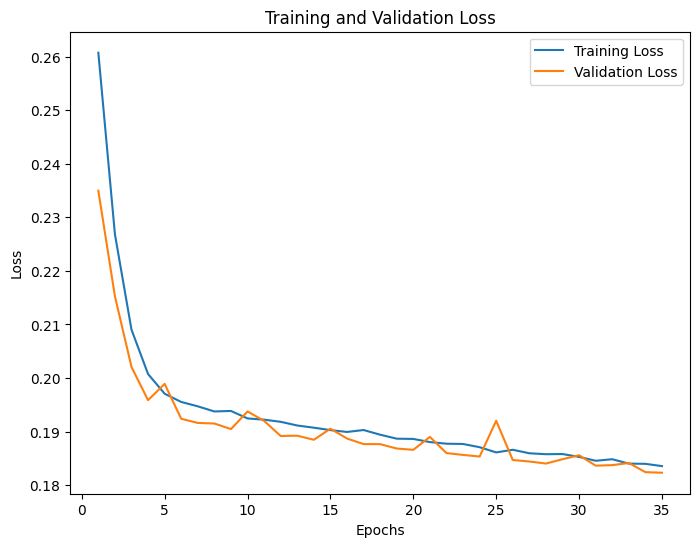

In [44]:
# Calculate AUROC for test predictions
model.eval()
test_scores = []
test_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        test_scores.extend(outputs.cpu().squeeze().tolist())
        test_labels.extend(labels.cpu().tolist())

# Plot training/validation loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
plt.plot(range(1, len(valid_losses)+1), valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Test AUROC: 0.8072


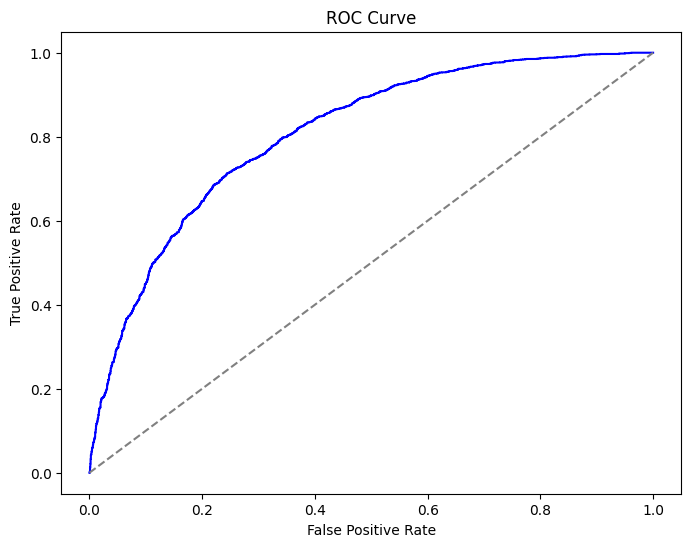

In [45]:
test_auroc = roc_auc_score(test_labels, test_scores)
print(f"Test AUROC: {test_auroc:.4f}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, test_scores)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()